<a href="https://colab.research.google.com/github/ioskn/mldl_htwg/blob/master/linear_methods/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook demonstrating Linear Regression (Curve Fitting)

This notebook demonstrates the curve fitting part of linear regression. 

*Please note that we did not split the data into a training and test set as one should do*. This notbook is just for illustration.

In [1]:
# Some imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

#To make ploting consitent
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline
plt.style.use('default')
np.random.seed(42)
import pandas as pd

In [2]:
# The adverting data set from ILSR
import os
from urllib.request import urlretrieve
if not os.path.isfile('Advertising.csv'):
    print("Downloading")
    urlretrieve('https://raw.githubusercontent.com/ioskn/mldl_htwg/master/data/Advertising.csv',filename = 'Advertising.csv')
advertising = pd.read_csv('Advertising.csv', usecols=[1,2,3,4])
advertising.insert(0, 'Intercept',np.ones((200,1)))
advertising

,Intercept,TV,Radio,Newspaper,Sales
0,1.0,230.1,37.8,69.2,22.1
1,1.0,44.5,39.3,45.1,10.4
2,1.0,17.2,45.9,69.3,9.3
3,1.0,151.5,41.3,58.5,18.5
4,1.0,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,1.0,38.2,3.7,13.8,7.6
196,1.0,94.2,4.9,8.1,9.7
197,1.0,177.0,9.3,6.4,12.8
198,1.0,283.6,42.0,66.2,25.5


In [3]:
y = np.asmatrix(advertising['Sales'])[0].T
X = np.asmatrix(advertising.iloc[:,0:4])
N = y.shape[0] #200
print(X[0:3])
y.shape, X.shape

[[  1.  230.1  37.8  69.2]
 [  1.   44.5  39.3  45.1]
 [  1.   17.2  45.9  69.3]]


((200, 1), (200, 4))

In [4]:
w = np.ones((4)) #Setting w = 1 just for demonstration w is not trained
d = np.matmul(X,w)
d[:,1:10]

matrix([[129.9, 133.4, 252.3, 251. , 133.6, 114.8, 152.4,  12.7, 224.6]])

### Solving the linear regression

$$
w = (𝑋^𝑇 𝑋)^{(−1)} 𝑋^𝑇 𝑦
$$

Since this is the estimate of the parameters, we can also write it as:
$$
\hat{w} = (𝑋^𝑇 𝑋)^{(−1)} 𝑋^𝑇 𝑦
$$

####  "By Hand"

Just for demonstration of the formula. Numerically probably not very stable.

In [5]:
XTX = np.matmul(X.T,X)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, X.T)
w = np.matmul(XTXIXT,y)
w

matrix([[ 2.93888937e+00],
        [ 4.57646455e-02],
        [ 1.88530017e-01],
        [-1.03749304e-03]])

In [6]:
y_pred = np.matmul(X,w)
np.mean(np.square((y_pred.flatten() - y.flatten()))) # The MSE

2.784126314510936

#### Using sklearn

In [7]:
from sklearn.linear_model import LinearRegression
Xa = np.asarray(X) #sklearn is picky and needs numpy arrays
ya = np.asarray(y)
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(Xa,ya)
model_skl.coef_

array([[ 2.93888937e+00,  4.57646455e-02,  1.88530017e-01,
        -1.03749304e-03]])

### Looking at the solution

2.784126314510936

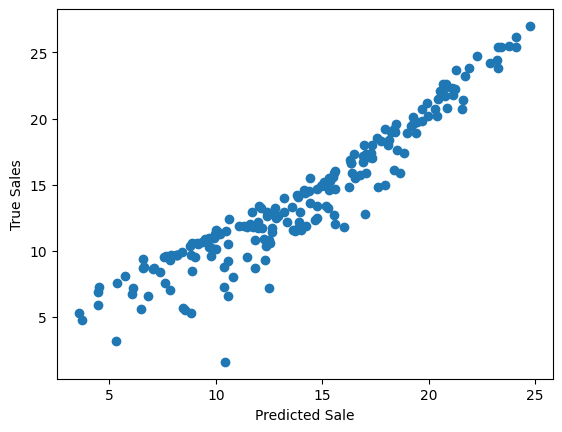

In [8]:
y_pred = np.matmul(X,w)
plt.scatter([y_pred[:,0]], [y[:,0]])
plt.xlabel('Predicted Sale')
plt.ylabel('True Sales')

np.mean(np.square((y_pred[:,0] - y[:,0]))) # The MSE

### Using gradient descent [Just for reference]

Linear regression is best solved in closed form (see above). The snippet below is just to illustrate how easily we can optimize the MSE with automatic differentiation. We use JAX, a near drop-in replacement for NumPy that provides grad.

In [9]:
import jax
import jax.numpy as jnp

X = jnp.asarray(X, dtype=jnp.float32)
y = jnp.asarray(y, dtype=jnp.float32).reshape(-1, 1)
w = jnp.asarray(1.2 * jnp.asarray(w, dtype=jnp.float32)).reshape(-1, 1)

def mse_loss(w, X, y):
    y_hat = jnp.matmul(X,w) # matrix multiplication X w 
    return jnp.mean((y - y_hat)**2)

grad_fn = jax.grad(mse_loss)

lr = 1e-5
steps = 5000

for i in range(steps):
    g = grad_fn(w, X, y)          # autodiff gradient wrt w
    w = w - lr * g                 # immutable arrays -> rebind
    if i % 500 == 0:
        print(i, np.array(w.T), float(mse_loss(w, X, y)))

print("final w:", np.array(w.T))

0 [[ 3.5266113e+00  4.5275405e-02  2.2475350e-01 -3.0620126e-03]] 4.7378830909729
500 [[ 3.5252895   0.04400369  0.18663946 -0.00727239]] 2.8401074409484863
1000 [[ 3.5244145   0.04414186  0.18253964 -0.00499668]] 2.8343136310577393
1500 [[ 3.52358     0.04416434  0.18193196 -0.00464946]] 2.8340442180633545
2000 [[ 3.5227456   0.04416965  0.18184884 -0.00459298]] 2.8338992595672607
2500 [[ 3.5219111   0.04417236  0.18184471 -0.00458022]] 2.833756923675537
3000 [[ 3.5210767   0.04417473  0.18185216 -0.00457412]] 2.8336150646209717
3500 [[ 3.5202422   0.04417707  0.18186039 -0.00456841]] 2.833472728729248
4000 [[ 3.5194077   0.04417935  0.18186992 -0.00456331]] 2.83333158493042
4500 [[ 3.5185733   0.04418163  0.1818795  -0.00455824]] 2.8331902027130127
final w: [[ 3.5177405   0.0441839   0.18188904 -0.00455319]]


Comparison, longer traning would yield better results. 